### TorchScript入门：Introduction to TorchScript
在这份tutorial里我们会覆盖:

1.最基本的PyTorch授权的模型，包括:  
模块
定义向前函数
把模块组装进等级模块

2.把PyTorch模块转换进TorchScript，我们表现好的利用运行时间记录现有的模块。
使用scripting来直接组装一个模块
怎么样组装两种方法
保存和加载TorchScript模块

In [ ]:
import torch # This is all you need to use both PyTorch and TorchScript!
print(torch.__version__)

### Basics of PyTorch Model Authoring
让我们开始定义简单的模块。一个模块是组成PyTorch的基本单元。它包括:

1.一个constructor，它可以为模块创新准备。
2.一组参数和子模块。它被constructor初始化以及可以在模块创新时被使用。
3.一个向前函数。这是模块被启动时运行的代码。
让我们用一个小例子检查一下:

In [ ]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()

    def forward(self, x, h):
        new_h = torch.tanh(x + h)
        return new_h, new_h

my_cell = MyCell()
x = torch.rand(3, 4)
h = torch.rand(3, 4)
print(my_cell(x, h))

因此，现在我们:
创建了一个类，它的子类是torch.nn.Module。

1.定义一个constructor。这个constructor没有做很多，只是为了super来call了constructor。
2.定义一个向前函数，这包含了输入和两个输出的返回。这实际上只包含了向前。
3.函数不是很重要，但是它是一种虚假的RNN cell，这是一个使用在循环里的函数。

我们为模块添加实际的东西，创建x和y，它们只是随机值3x4的评价矩阵。然后，我们使用my_cell(x, h)来启动cell。这反过来也call了我们的向前函数。

让我们做一些更有趣的事情:


In [ ]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.linear = torch.nn.Linear(4, 4)

    def forward(self, x, h):
        new_h = torch.tanh(self.linear(x) + h)
        return new_h, new_h

my_cell = MyCell()
print(my_cell)
print(my_cell(x, h))

我们重新定义了我们的MyCell模块，但是这一次我们加入了self.linear特性，我们在向前函数中启动了self.linear。

哪里究竟发生了什么？torch.nn.Linear是一个PyTorch标准库模块。就像MyCell,它可以被使用call语法来启动。我们正在创建等级模块。

在模块中打印给一个子模块等级类的可视化的展示。在我们的例子中，我们可以看到我们的线性子类和它的参数。

通过这样组装模块，我们可以用可以重复使用的模块来简短的以及可读的创建模型。

你应该有注意到输出里的grad_fn。这是一个自动化偏微分的具体PyTorch方法，叫做自动梯度。简单地来说，这套系统允许通过潜在复杂项目来计算偏微分。这个设计允许巨大的模型灵活性。

现在，让我们检查所说的灵活性:

我们重新定义了我们的MyCell类，但是这里我们定义的是MyDecisionGate。这个模块利用控制流。控制流包括像循环和if语句的东西。

很多框架包含了在完整项目代表中计算符号偏微分方法。然而，在PyTorch中，我们使用梯度tape。我们在操作发生时记录它们，以及在计算偏微分时重新利用反向传播。这样，这个框架无需在语言中对所有constructs表明定义偏微分。

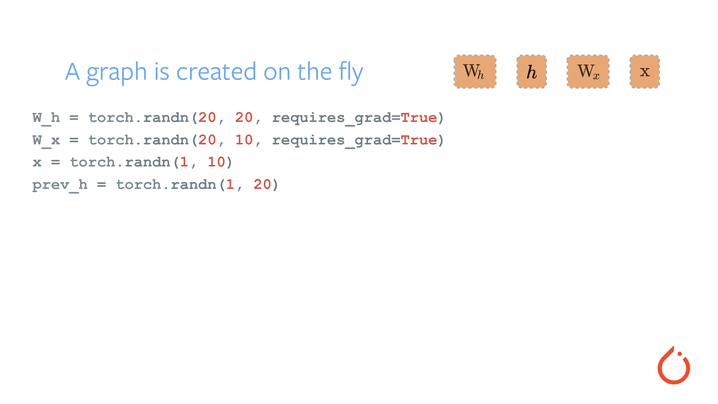

### Basics of TorchScript
现在让我们运行我们的例子，以及看看我们怎么来应用TorchScript。

简单地来说，TorchScript提供工具来捕捉你模型的定义，甚至是PyTorch可塑性和动态本质中。让我们从call记录开始。

### Tracing Modules

In [ ]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.linear = torch.nn.Linear(4, 4)

    def forward(self, x, h):
        new_h = torch.tanh(self.linear(x) + h)
        return new_h, new_h

my_cell = MyCell()
x, h = torch.rand(3, 4), torch.rand(3, 4)
traced_cell = torch.jit.trace(my_cell, (x, h))
print(traced_cell)
traced_cell(x, h)

我们倒带一下看看第二版本的MyCell类。在之前，我们充实它，但是这一次，我们呼叫torch.jit.trace，传进模块，然后把它传递到模型可见的例子的输入中。

实际上，它是怎么做的呢？它有启动模块，记录模块每次运行的操作，以及创建一个torch.jit.ScriptModule的实例(这里面TracedModule是一个实例)


TorchScript在Intermediate Representation (or IR)中记录它的定义，通常在图中代表深度学习。我们可以用.graph的特性来检查图。

In [ ]:
print(traced_cell.graph)

然而，这是非常低程度的代表以及更多的信息包含在图里，这是对于端用户不实用的。事实上，我们可以使用.code的特性来给代码Python语法翻译这段代码:

In [ ]:
print(traced_cell.code)

所以我们为什么要做这些？以下是几点原因:

1.TorchScript代码可以使用它自己的interpreter来启动，这基本上就是严格的Python interpreter了。这种interpreter没有获得全局Interpreter锁，以及那么多请求可以同时在一个实例上处理。

2.这样的格式让我们可以保存整个模型到硬盘以及加载它进另一个环境，例如在用另一种不是python语言写的服务器。

3.TorchScript给我们展示了一种我们可以用代码做组装优化器来提供更有效执行。

4.TorchScript允许我们去与很多在项目中比独立操作需要一个更广阔视野后端／设备交互， 

我们可以看到启动traced_cell产生与Python模块一样的结果:


In [ ]:
print(my_cell(x, h))
print(traced_cell(x, h))

### Using Scripting to Convert Modules
我们使用模块中第二版本而不是control-flow-laden子模块是有原因的。让我们现在检验一下:

In [ ]:
class MyDecisionGate(torch.nn.Module):
  def forward(self, x):
    if x.sum() > 0:
      return x
    else:
      return -x

class MyCell(torch.nn.Module):
    def __init__(self, dg):
        super(MyCell, self).__init__()
        self.dg = dg
        self.linear = torch.nn.Linear(4, 4)

    def forward(self, x, h):
        new_h = torch.tanh(self.dg(self.linear(x)) + h)
        return new_h, new_h

my_cell = MyCell(MyDecisionGate())
traced_cell = torch.jit.trace(my_cell, (x, h))
print(traced_cell.code)

看看.code的输出，我们可以看到if-else分支哪里也找不到！为什么？跟踪就如我们所说的那样:运行代码。记录发生和建立在ScriptModule上的操作。不幸的是，像控制流一样的东西被抹去了。

我们怎么能够有信心代表这个模块呢？我们提供了一个脚本编辑器，这可以直接转换我们的Python源代码到TorchScript。让我们使用脚本编辑器转换MyDecisionGate
:

In [ ]:
scripted_gate = torch.jit.script(MyDecisionGate())

my_cell = MyCell(scripted_gate)
traced_cell = torch.jit.script(my_cell)
print(traced_cell.code)

看！我们现在在TorchScript中捕捉到我们程序的行为。让我们尝试运行这段程序:

In [ ]:
# New inputs
x, h = torch.rand(3, 4), torch.rand(3, 4)
traced_cell(x, h)

### Mixing Scripting and Tracing
一些情境下用跟踪的方式而不是脚本的方式call(比如说一个模块有很多结构上的决定是基于恒定的Python值而不是出现在TorchScrip上)。这种情况下，脚本和跟踪可以混为一谈：torch.jit.script会跟跟踪模块的代码一样，以及跟踪会和脚本代码一致。

接下来是第一个例子：

In [ ]:
class MyRNNLoop(torch.nn.Module):
    def __init__(self):
        super(MyRNNLoop, self).__init__()
        self.cell = torch.jit.trace(MyCell(scripted_gate), (x, h))

    def forward(self, xs):
        h, y = torch.zeros(3, 4), torch.zeros(3, 4)
        for i in range(xs.size(0)):
            y, h = self.cell(xs[i], h)
        return y, h

rnn_loop = torch.jit.script(MyRNNLoop())
print(rnn_loop.code)

第二个例子:

In [ ]:
class WrapRNN(torch.nn.Module):
  def __init__(self):
    super(WrapRNN, self).__init__()
    self.loop = torch.jit.script(MyRNNLoop())

  def forward(self, xs):
    y, h = self.loop(xs)
    return torch.relu(y)

traced = torch.jit.trace(WrapRNN(), (torch.rand(10, 3, 4)))
print(traced.code)

这样，scripting和tracing可以单独使用或者同时使用。

### Saving and Loading models

我们提供在一个archive格式下保存和加载TorchScript模块从／到硬盘上的APIs。这个格式包括代码，参数，特性和debug信息，意味着archive是一个模型独立代表，它可以逐步加载整个模型。让我们保存和加载我们的wrapped RNN 模块：

In [ ]:
traced.save('wrapped_rnn.zip')

loaded = torch.jit.load('wrapped_rnn.zip')

print(loaded)
print(loaded.code)

正如你可以看到的，序列化保存了模块的等级以及我们彻底检查过的代码。这个模型可以同时加载，比如说，到对python友好的C++执行器。

### Further Reading
我们已经完成了这份tutorial!对于更多提及到的demonstration，使用TorchScript: https://colab.research.google.com/drive/1HiICg6jRkBnr5hvK2-VnMi88Vi9pUzEJ 检查NeurIPS demo来转换机器翻译模型。